In [10]:
from sklearnex import patch_sklearn
patch_sklearn()
import math
#from langdetect import detect,detect_langs
import validators
import spacy
from spacy import displacy
#import en_core_web_sm

import pandas as pd
import numpy as np
import os
import email
import email.policy
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import RegexpTokenizer,word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re
import heapq
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.feature_extraction.text import HashingVectorizer

## CARREGANDO BASE DE DADOS

In [5]:
'''teste = pd.read_csv("spam_ham_dataset.csv").sample(frac=1)
teste2 =pd.read_csv("emails.csv").sample(frac=1)
targetTest2 = teste2["spam"]
teste = teste.drop(columns=["Unnamed: 0","label_num"])
teste = teste.replace({"ham":0,"spam":1})
targetTest = teste["label"]'''

database = pd.read_csv("Database/enron_spam_data.csv")
database = database.drop(columns=["Message ID","Date"])
database = database.replace({"ham":0,"spam":1})
database = database.drop(columns=["Subject"])
database = database.dropna()
database = database.sample(frac=1)
target = database["Spam/Ham"]

In [6]:
def removePunctuation(text):
    ponctuation = list(punctuation)

    for i in ponctuation:
        text = text.replace(i, "")

    return text

stopWords = set(stopwords.words('english')  + list(punctuation) + list(STOPWORDS))
stopWords.add("subject")
stem = PorterStemmer()
lemmatizer = WordNetLemmatizer()

regex = re.compile(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+')

def wordsPreProcessing(email):
    if email is None:
        return 'empty'

    newText = ""

    e = email.split()

    for i in range(0,len(e)):
        if validators.url(e[i]):
            e[i] = "URLLL"

        if re.fullmatch(regex,e[i]):
            e[i] = "EMAILLL"

    for text in word_tokenize(email.lower()):
        text = removePunctuation(text)
        if text not in stopWords and not text.isdigit():
            newText += lemmatizer.lemmatize(text) + " "

    return newText

def NERProcessing(emails):
    emailsPreProcessedLocal = []

    spacy.require_gpu()
    NER = spacy.load("en_core_web_sm")
    NER.disable_pipe("parser")
    NER.add_pipe("sentencizer")
    NER.add_pipe("merge_entities")

    for doc in NER.pipe(emails, n_process=2):
        emailsPreProcessedAux = []

        for t in doc:
            if not t.ent_type_:
                emailsPreProcessedAux.append(t.text)
            else:
                emailsPreProcessedAux.append((t.ent_type_ + t.ent_type_[-1]).upper())

        emailsPreProcessedAux = " ".join(emailsPreProcessedAux)
        emailsPreProcessedLocal.append(wordsPreProcessing(emailsPreProcessedAux))

    return emailsPreProcessedLocal

In [3]:
def bagOfWord(emails):
    wordCount = {}

    for email in emails:
        for i in email.split():
            if i not in wordCount.keys():
                wordCount[i] = 1
            else:
                wordCount[i] += 1

    return wordCount

In [4]:
# # emailsTest = []
# #
# # for email in np.array(database["Message"]):
# #     emailsTest.append(NERProcessing(email))
# #
# # NERDataframe = pd.DataFrame(emailsTest, columns=["email"])
# # NERDataframe.to_csv('Database/dataBaseWithNER.csv')
# # NERDataframe
# a = wordsPreProcessing(database["Message"].array[0])
# a


0:04:20.490928


In [ ]:
textos = []
ini = datetime.now()

emailsPreProcessed = NERProcessing(database["Message"])

#print(emailsPreProcessed)
#print()
print(datetime.now() - ini)

In [ ]:
NERDataframe = pd.DataFrame(emailsPreProcessed, columns=["email"])
NERDataframe["target"] = target.values

NERDataframe.to_csv('Database/dataBaseWithNER.csv')
NERDataframe

In [7]:
database = pd.read_csv("Database/dataBaseWithNER.csv")

database = database.drop(columns=["Unnamed: 0"])
database = database.dropna()
target = database["target"].array
database

,email,target
0,start date hourahead timee cardinall hou...,0
1,service long desk price structure deal quote ...,0
2,start date cardinall hourahead timee card...,0
3,start date hourahead timee cardinall anc...,0
4,cardinall deliverable revenue management marke...,0
...,...,...
33340,bio matrix scientific group symbo bmxg p...,1
33341,cardinall step away hot naked webcam girl liv...,1
33342,need pill increase performance click seroius ...,1
33343,datee final nom inlet hpl eastrans car...,0


In [8]:
#wordCount = bagOfWord(emailsText)

#wordFrequency = heapq.nlargest(100, wordCount, wordCount.get)

#print(wordFrequency)
emailsText = []
for email in database["email"]:
  emailsText.append(email)



In [87]:
print(len(emailsText))

33341


In [27]:
tfidfVectorizer = TfidfVectorizer(analyzer="word",max_features=2100)
#tfidfVectorizer = TfidfVectorizer(analyzer="word")

tfidfTransform = tfidfVectorizer.fit_transform(emailsText)

print(tfidfTransform)

  (0, 1593)	0.26470874972054786
  (0, 1098)	0.35510965844285625
  (0, 671)	0.34195431682743727
  (0, 535)	0.3142974755284843
  (0, 1663)	0.2523502664970415
  (0, 249)	0.0882891907360702
  (0, 1904)	0.14585506953003874
  (0, 861)	0.6284245513555586
  (0, 440)	0.21615559903629922
  (0, 1796)	0.23177737406989862
  (1, 1893)	0.12322552160237797
  (1, 432)	0.16667910623163265
  (1, 1405)	0.2023515027069684
  (1, 1910)	0.21821281232441633
  (1, 773)	0.252147976524646
  (1, 1814)	0.24651126769711865
  (1, 2073)	0.1442701571707954
  (1, 1342)	0.19540664510107641
  (1, 1962)	0.21745283397516152
  (1, 809)	0.3089620245082559
  (1, 1457)	0.1585651873255142
  (1, 297)	0.26945510026530634
  (1, 1102)	0.268483606738479
  (1, 105)	0.2304674552193428
  (1, 1514)	0.2375975711797802
  :	:
  (33340, 734)	0.1499328111246709
  (33340, 1274)	0.08454655116352783
  (33340, 1509)	0.09899129231263658
  (33340, 637)	0.15067486614547307
  (33340, 1426)	0.1353816153153684
  (33340, 1339)	0.22427638740937866
  (333

In [28]:
tfidfLabels = tfidfVectorizer.get_feature_names()
tfidfLabels

C:\Users\victo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'ability',
 'able',
 'absolutely',
 'abuse',
 'accept',
 'acceptance',
 'accepted',
 'access',
 'according',
 'account',
 'accounting',
 'accuracy',
 'achieve',
 'acquire',
 'acquired',
 'acquisition',
 'acrobat',
 'act',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'acy',
 'ad',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'additionally',
 'address',
 'administration',
 'adobe',
 'adult',
 'advance',
 'advanced',
 'advantage',
 'advertisement',
 'advertising',
 'advice',
 'advise',
 'advised',
 'advises',
 'advisor',
 'aep',
 'affair',
 'affect',
 'affiliate',
 'affiliated',
 'affordable',
 'age',
 'agency',
 'agenda',
 'agent',
 'aggressive',
 'agree',
 'agreed',
 'agreement',
 'ahead',
 'aid',
 'ail',
 'aimee',
 'air',
 'al',
 'alert',
 'alias',
 'align',
 'allen',
 'allocated',
 'allocation',
 'allow',
 'allowed',
 'allows',
 'alternative',
 'america',
 'amid',
 'amount',
 'amy',
 'analysis',
 'analyst',
 'ancillary',
 'andmanyother',
 'andrew',


In [29]:
dfTfidfArray = pd.DataFrame(data=tfidfTransform.toarray(), columns=tfidfLabels)


In [91]:
dfTfidfArray

,aa,ability,able,absolutely,abuse,accept,acceptance,accepted,access,according,...,xanax,xl,xp,yahoo,year,yes,yield,yo,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.143700,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33336,0.0,0.0,0.0,0.0,0.0,0.0,0.015667,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.013857,0.0,0.0,0.0,0.0,0.0,0.0
33337,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.207355,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
33338,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
33339,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:

dfTfidfArray.insert(len(dfTfidfArray.columns), "Target", target, True)
dfTfidfArray


,aa,ability,able,absolutely,abuse,accept,acceptance,accepted,access,according,...,xl,xp,yahoo,year,yes,yield,yo,young,zone,Target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.143700,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33336,0.0,0.0,0.0,0.0,0.0,0.0,0.015667,0.0,0.000000,0.0,...,0.0,0.0,0.013857,0.0,0.0,0.0,0.0,0.0,0.0,1
33337,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.207355,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
33338,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
33339,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
#dfTfidfArray.to_csv("dataset.csv", sep='\t', encoding='utf-8')

C:\Users\victo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\victo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


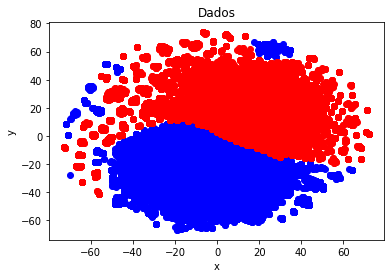

In [31]:
model = TSNE(n_components=2, random_state=0)
#model = PCA(n_components=50, svd_solver='full')
array_red = model.fit_transform(dfTfidfArray)

df_tsne = pd.DataFrame(array_red)

target = dfTfidfArray["Target"].array

df_tsne['Target'] = target
df_tsne_c1 = df_tsne[df_tsne['Target'] == 0]

df_tsne_c2 = df_tsne[df_tsne['Target'] == 1]

plt.scatter(df_tsne_c1[0].array,df_tsne_c1[1].array,marker='o',color='blue')

plt.scatter(df_tsne_c2[0].array,df_tsne_c2[1].array,marker='o',color='red')

plt.title('Dados')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [93]:
df_features = dfTfidfArray.drop(columns=['Target'])
#df_tsneTarget = df_tsne["Target"].array
#df_tsneFeatures = df_tsne.drop(columns=['Target'])

df_features

,aa,ability,able,absolutely,abuse,accept,acceptance,accepted,access,according,...,xanax,xl,xp,yahoo,year,yes,yield,yo,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.143700,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33336,0.0,0.0,0.0,0.0,0.0,0.0,0.015667,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.013857,0.0,0.0,0.0,0.0,0.0,0.0
33337,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.207355,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
33338,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
33339,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

def getModel():
      return LogisticRegression(max_iter=400)
#     return DecisionTreeClassifier()
#     return RandomForestClassifier()
#     return LinearSVC()
#     return MultinomialNB()

In [95]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values,target,test_size=0.2)
modelo = getModel().fit(X_treino,y_treino)
score = modelo.score(X_teste,y_teste)
#score = modelo.score(["alo"],[1])
score

0.972409656620183

In [96]:
scores = cross_val_score(getModel(),df_features.values,target,cv=10)

scores.mean()

0.9761254855475681

In [97]:
predicoes = cross_val_predict(getModel(), df_features.values, target, cv=10)

cm = confusion_matrix(target,predicoes,labels=[0, 1])

cm_df = pd.DataFrame(cm, columns=[0, 1])

cm_df

,0,1
0,15931,562
1,234,16614


In [10]:

vectorizer = CountVectorizer(max_features=2100)
X = vectorizer.fit_transform(emailsText)

bag = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

bag.head()

,aa,ability,able,absolutely,abuse,accept,acceptance,accepted,access,according,...,xanax,xl,xp,yahoo,year,yes,yield,yo,young,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_treino, X_teste, y_treino, y_teste = train_test_split(bag.values,target,test_size=0.2)
modelo = getModel().fit(X_treino,y_treino)
score = modelo.score(X_teste,y_teste)
#score = modelo.score(["alo"],[1])
score

0.9760083970610286

In [12]:
predicoes = cross_val_predict(getModel(), bag.values, target, cv=10)

cm = confusion_matrix(target,predicoes,labels=[0, 1])

cm_df = pd.DataFrame(cm, columns=[0, 1])

cm_df

,0,1
0,15958,535
1,230,16618


In [22]:
vectorizer = HashingVectorizer(n_features=2100)
X = vectorizer.fit_transform(emailsText)
hashing = pd.DataFrame(X.toarray())
hashing

,0,1,2,3,4,5,6,7,8,9,...,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099
0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33336,-0.028318,0.0,0.0,0.014159,-0.028318,0.0,0.0,0.0,0.0,0.0,...,0.014159,0.0,0.0,0.0,0.0,0.0,-0.028318,0.0,0.0,0.0
33337,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
33338,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
33339,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [23]:
X_treino, X_teste, y_treino, y_teste = train_test_split(hashing.values,target,test_size=0.2)
modelo = getModel().fit(X_treino,y_treino)
score = modelo.score(X_teste,y_teste)
#score = modelo.score(["alo"],[1])
score

0.9578647473384315

In [26]:
predicoes = cross_val_predict(getModel(), hashing.values, target, cv=10)

cm = confusion_matrix(target,predicoes,labels=[0, 1])

cm_df = pd.DataFrame(cm, columns=[0, 1])

cm_df

,0,1
0,15584,909
1,435,16413


In [109]:
emailsTest2 = []

for email in t["text"]:
    emailsTest2.append(NERProcessing(email))


C:\ProgramData\Anaconda3\lib\site-packages\spacy\language.py:1568: UserWarning: [W114] Using multiprocessing with GPU models is not recommended and may lead to errors.
  warnings.warn(Warnings.W114)


KeyboardInterrupt: 

In [ ]:
emailsTest3 = []

for email in teste["text"]:
    emailsTest3.append(wordsPreProcessing(email))
    
print("ok")

In [100]:
X_new_counts = tfidfVectorizer.transform(emailsTest2)

X_new_counts

NameError: name 'emailsTest2' is not defined

In [ ]:
#APAGAR DEPOIS

# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(emailsTest)
# X_train_counts.shape
#
# tf_transformer = TfidfTransformer()
# X_train_tfidf = tf_transformer.fit_transform(X_train_counts)
# X_train_tfidf.shape

In [ ]:
# ##APAGAR DEPOIS
# clf = getModel().fit(X_train_tfidf,target)
#
# X_new_counts = count_vect.transform(emailsTest2)
#
# X_new_tfidf = tf_transformer.transform(X_new_counts)
#
# predict = clf.predict(X_new_tfidf)
# print(len(emailsTest2))
# print(predict)
# print(targetTest2)
# print(teste2)
# print(clf.score(X_new_tfidf,targetTest2))
#
# #predicoesTest = cross_val_predict(modelo2, dfTfidfArrayFeaturesTest.values, dfTfidfArrayTargetTest, cv=10)
#
# cmTest = confusion_matrix(targetTest2,predict,labels=[0, 1])
#
# cm_dfTest = pd.DataFrame(cmTest, columns=[0, 1])
#
# cm_dfTest

In [ ]:
# dfTfidfArrayTest = pd.DataFrame(data=tfidfTransformTest.toarray(), columns=tfidfVectorizerTest.get_feature_names_out())
# dfTfidfArrayTest.insert(len(dfTfidfArrayTest.columns), "Target", target.array, True)
# dfTfidfArrayTest = dfTfidfArrayTest.sample(frac=1)
# dfTfidfArrayTest


In [ ]:
# modelTest = TSNE(n_components=2, random_state=0)
# #modelTest = PCA(n_components=50)
# array_redTest = modelTest.fit_transform(dfTfidfArrayTest)
#
# df_tsneTest = pd.DataFrame(array_redTest)
# df_tsneTest['Target'] = target.array
#
# df_tsne_c1Test = df_tsneTest[df_tsneTest['Target'] == 0]
#
# df_tsne_c2Test  = df_tsneTest[df_tsneTest['Target'] == 1]
#
# plt.scatter(df_tsne_c1Test[0].array,df_tsne_c1Test[1].array,marker='o',color='blue')
#
# plt.scatter(df_tsne_c2Test[0].array,df_tsne_c2Test[1].array,marker='o',color='red')
#
# plt.title('Dados')
# plt.xlabel('x')
# plt.ylabel('y')
#
# plt.show()


In [ ]:
# dfTfidfArrayTarget = dfTfidfArray["Target"].array
# dfTfidfArrayFeatures = dfTfidfArray.drop(columns=['Target'])
#
# print(dfTfidfArrayFeatures)
#
# dfTfidfArrayTargetTest = dfTfidfArrayTest["Target"].array
# dfTfidfArrayFeaturesTest = dfTfidfArrayTest.drop(columns=['Target'])
#
#
#
# print(dfTfidfArrayFeaturesTest)
# dfTfidfArrayTargetTest

In [ ]:
# dfTfidfArrayTargetTest2 = dfTfidfArrayTest2["Target"].array
# dfTfidfArrayFeaturesTest2 = dfTfidfArrayTest2.drop(columns=['Target'])

In [ ]:
# #from sklearn.svm import LinearSVC
#
# X_treino, X_teste, y_treino, y_teste = train_test_split(dfTfidfArrayFeaturesTest2.values,dfTfidfArrayTargetTest2,test_size=0.2)
# X_treinoTest, X_testeTest, y_treinoTest, y_testeTest = train_test_split(dfTfidfArrayFeaturesTest.values,dfTfidfArrayTargetTest,test_size=0.01)
# modelo = getModel().fit(X_treino,y_treino)
# modelo2 = getModel().fit(X_treinoTest,y_treinoTest)
# predict = modelo.predict(X_teste)
# #score = modelo.score(X_treinoTest,y_treinoTest)
# #score2 = modelo2.score(X_treino,y_treino)
#
# cmTest = confusion_matrix(y_teste,predict)
# cm_dfTest = pd.DataFrame(cmTest, columns=[0, 1])
#
# cm_dfTest

In [ ]:
#predicoesTest = cross_val_predict(modelo2, dfTfidfArrayFeaturesTest.values, dfTfidfArrayTargetTest, cv=10)

#cmTest = confusion_matrix(dfTfidfArrayTargetTest,predicoesTest,labels=[0, 1])

#cm_dfTest = pd.DataFrame(cmTest, columns=[0, 1])

#cm_dfTest